In [29]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
# Define the ticker symbol for Apple
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", )
data.columns = data.columns.get_level_values(0)
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1237, 6)


### Compute weights

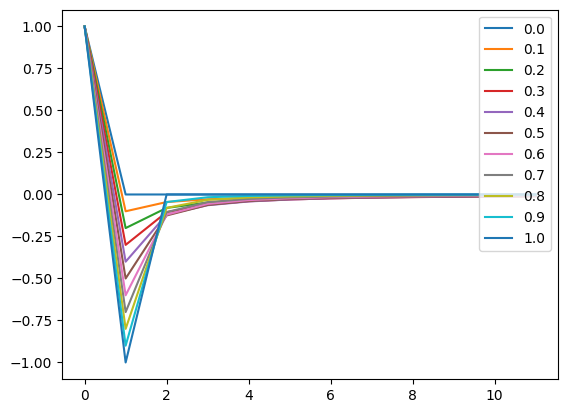

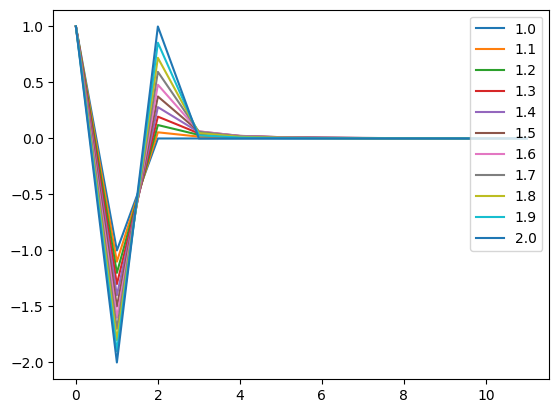

In [4]:
def getWeights(d, size):
    # thres > 0 drops insignificant weights
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1]/k * (d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w

def plotWeights(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        d = d.round(1)
        w_ = getWeights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot()
    ax.legend(fontsize=10, loc='upper right')
    plt.show()
    return

#----------------------------------------
if __name__ == '__main__':
    plotWeights(dRange=[0,1], nPlots=11, size=12)
    plotWeights(dRange=[1,2], nPlots=11, size=12)

### Standard FracDiff (Expanding Window)

In [5]:
def fracDiff(series, d, thres=.01):
    '''
    Increase width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily bounded [0,1]
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].ffill().dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue #exclude NAs
            df_[loc] = np.dot(w[-(iloc+1):, :].T, seriesF.loc[:loc])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [6]:
data_log = data.apply(np.log)

In [7]:
data_frac = fracDiff(data_log, d=.4, thres=.05)
data_frac.shape

(1183, 6)

In [8]:
def two_in_1(frac_df, df, figsize=(12, 6)):
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=figsize)
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('FracDiff Close', color=color)
    ax1.plot(frac_df, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Close', color=color)  # we already handled the x-label with ax1
    ax2.plot(df, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

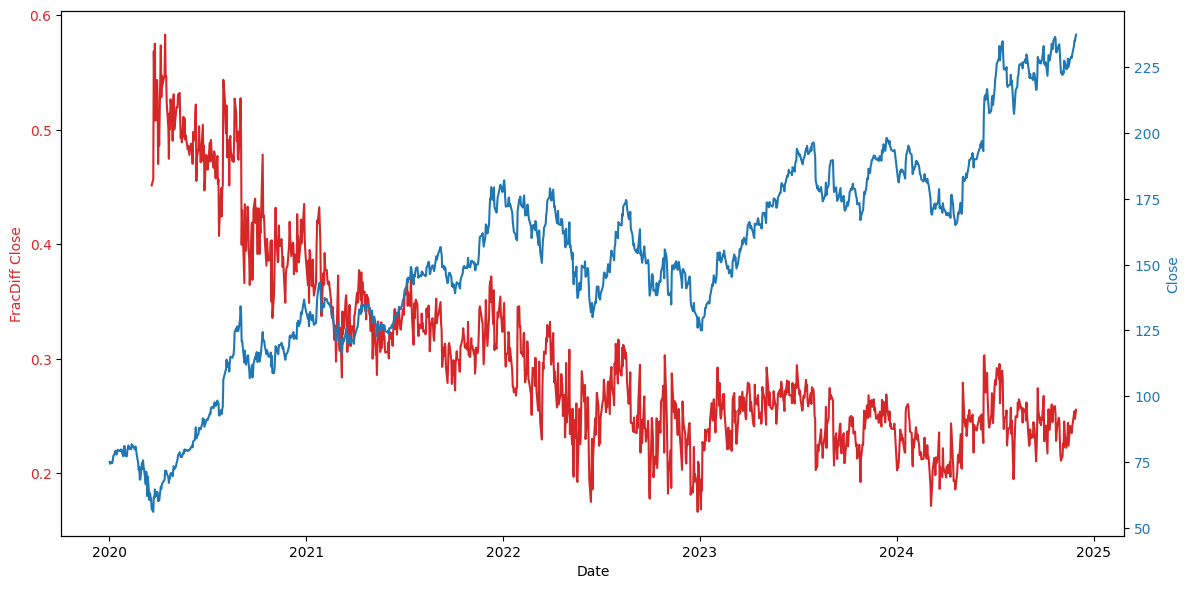

In [9]:
two_in_1(data_frac['Close'], data['Close'])

### Fixed-Width Window Fracdiff

In [10]:
def getWeights_FFD(d, thres=1e-5):
    w=[1.]
    if thres <= 0:
        print("Threshold must be positive, set to 1e-5")
        thres = 1e-5
    k = 1
    while abs(w[-1]) >= thres:
        w_ = -w[-1]/k*(d-k+1) 
        k += 1
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w


In [103]:
def fracDiff_FFD(series, d, thres=1e-5):
    w = getWeights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    if not isinstance(series, pd.DataFrame):
        series = pd.DataFrame(series)
    for name in series.columns:
        seriesF, df_ = series[[name]].ffill().dropna(), pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [12]:
data_frac_FFD = fracDiff_FFD(data_log, d=0.4, thres=0.0001)
data_frac_FFD.shape

(955, 6)

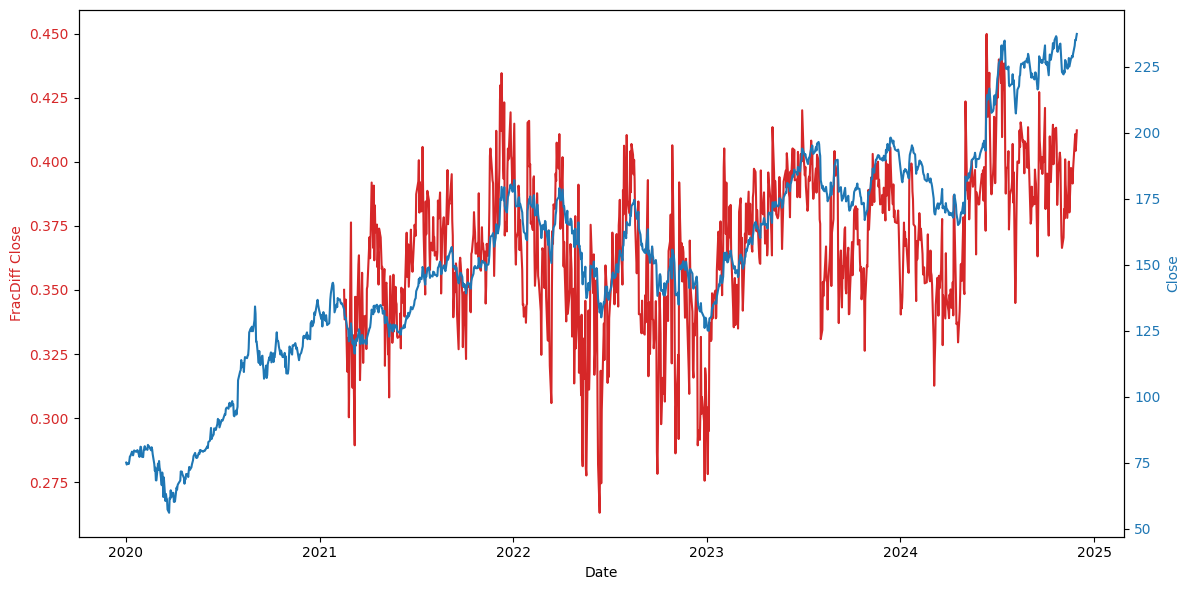

In [13]:
two_in_1(data_frac_FFD['Close'], data['Close'])

### Test the correlation

In [14]:
from statsmodels.tsa.stattools import adfuller
adfuller(data_frac_FFD['Close'], maxlag=1, regression='c', autolag=None)

(np.float64(-7.888447039926264),
 np.float64(4.503422143973671e-12),
 1,
 953,
 {'1%': np.float64(-3.4372303791313144),
  '5%': np.float64(-2.864577551835195),
  '10%': np.float64(-2.568387363624452)})

### Finding the minimal d that passes the adf test

In [15]:
def plotMinFFD(df):
    from statsmodels.tsa.stattools import adfuller
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = df.copy()
    for d in np.linspace(0,1,11):
        df1 = np.log(df0[['Close']]).resample('1D').last()
        df2 = fracDiff_FFD(df1, d, thres=0.01)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0,1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4])+[df2[4]['5%']] + [corr]
    
    out[['adfStat', 'corr']].plot(secondary_y='adfStat', figsize=(12,6))
    plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    return

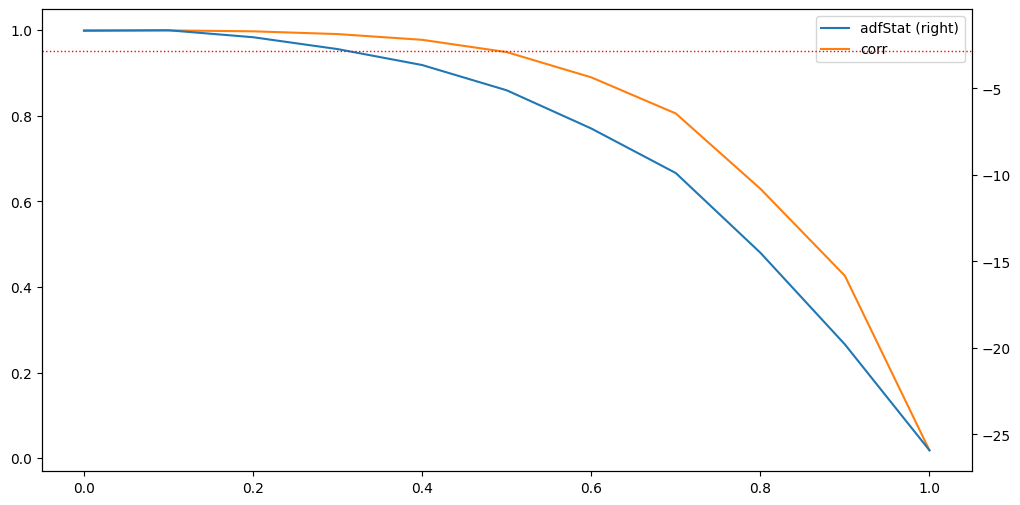

In [16]:
plotMinFFD(data)

## Exercise

5.1 Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:
1. Compute the ADF statistic on this series. What is the p-value?
2. Compute the cumulative sum of the observations. This is a non-stationary series without memory.
    - What is the order of integration of this cumulative series?
    - Compute the ADF statistic on this series. What is the p-value?
3. Differentiate the series twice. What is the p-value of this over-differentiated series?

Generate a time series from an IID Gaussian random process

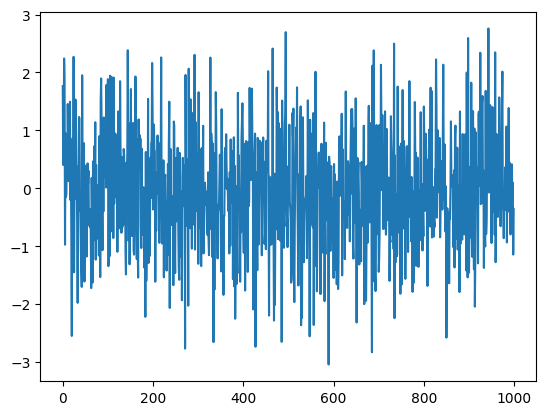

In [135]:
n = 1000  # Number of samples
mu = 0   # Mean of the Gaussian distribution
sigma = 1  # Standard deviation of the Gaussian distribution

# Generate IID Gaussian random process
np.random.seed(0)
time_series = np.random.normal(mu, sigma, n)
plt.plot(time_series)
plt.show()

1. Compute the ADF statistic on this series. What is the p-value?

In [137]:
adfuller(time_series)

(np.float64(-32.462559337689974),
 0.0,
 0,
 999,
 {'1%': np.float64(-3.4369127451400474),
  '5%': np.float64(-2.864437475834273),
  '10%': np.float64(-2.568312754566378)},
 np.float64(2742.307153840103))

2. Compute the cumulative sum of the observations. This is a non-stationary series without memory.
    - What is the order of integration of this cumulative series?
    - Compute the ADF statistic on this series. What is the p-value?

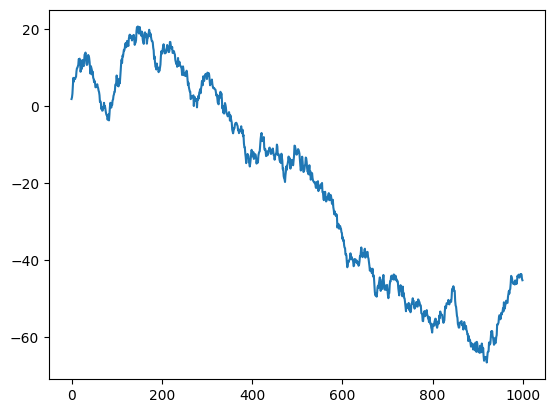

(np.float64(-0.5437433594783736),
 np.float64(0.8831939389121154),
 0,
 999,
 {'1%': np.float64(-3.4369127451400474),
  '5%': np.float64(-2.864437475834273),
  '10%': np.float64(-2.568312754566378)},
 np.float64(2742.7897756722487))

In [138]:
time_series_cum = time_series.cumsum()
plt.plot(time_series_cum)
plt.show()
adfuller(time_series_cum)

3. Differentiate the series twice. What is the p-value of this over-differentiated series?

In [20]:
time_series_diff2 = np.diff(np.diff(time_series))
adfuller(time_series_diff2)

(np.float64(-14.204117576946395),
 np.float64(1.7669737066256128e-26),
 22,
 975,
 {'1%': np.float64(-3.43707471791689),
  '5%': np.float64(-2.8645089073679597),
  '10%': np.float64(-2.5683508010519396)},
 np.float64(2985.56870898545))

5.2 Generate a time series that follows a sinusoidal function. This is a stationary series with memory.
1. Compute the ADF statistic on this series, what is the p-value?

(np.float64(-0.0002500851112001304),
 np.float64(0.9585113993093012),
 38,
 9961,
 {'1%': np.float64(-3.4310066595695945),
  '5%': np.float64(-2.861830204343065),
  '10%': np.float64(-2.5669244706354584)})

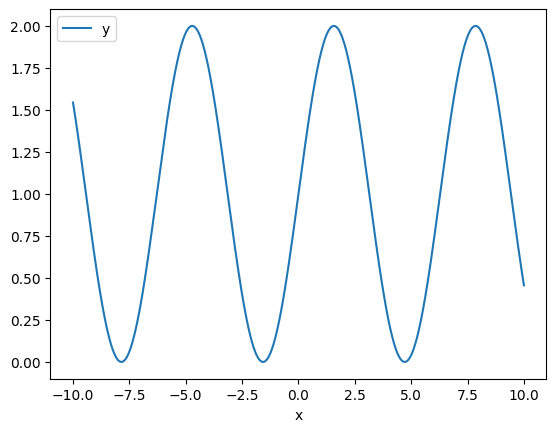

In [163]:
x = np.linspace(-10, 10, 10000)
y = np.sin(x) + 1
data_sin = pd.DataFrame({'x': x, 'y': y}).set_index('x')
data_sin.plot()
adfuller(y, autolag=None)

2. Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.
* Compute the ADF of this series, what is the p-value?

(np.float64(35.831264424590486),
 1.0,
 25,
 9974,
 {'1%': np.float64(-3.4310058034664337),
  '5%': np.float64(-2.8618298260383197),
  '10%': np.float64(-2.566924269263309)},
 np.float64(-547608.1372727538))

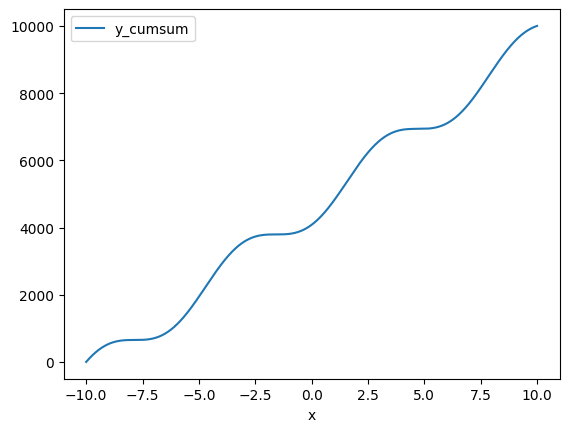

In [164]:
data_sin['y_cumsum'] = data_sin['y'].cumsum()

data_sin[['y_cumsum']].plot()
adfuller(data_sin['y_cumsum'])

* Apply an expanding window fracdiff, with t = 1E-2. For what minimum d value do you get a p-value below 5%?

In [192]:
min_value(y_shifted, thres=1e-5, func = fracDiff_FFD)

np.float64(0.020202)

In [193]:
min_value(y_shifted, thres=1e-2, func=fracDiff)

np.float64(0.020202)

In [190]:
y_shifted

,Shifted_series
1,1.479426
2,2.960605
3,4.443538
4,5.928221
5,7.414652
...,...
9996,10471.274929
9997,10473.272219
9998,10475.269359
9999,10477.266346


In [177]:
y_shifted['Shifted_series'] = data_sin['y_cumsum'].values

In [179]:
data_sin[['y_cumsum']]

,y_cumsum
x,
-10.000000,1.544021
-9.998000,3.086363
-9.996000,4.627023
-9.993999,6.165999
-9.991999,7.703290
...,...
9.991999,9998.165999
9.993999,9998.627023
9.996000,9999.086363


In [168]:
min_value(data_sin[['y_cumsum']], func = fracDiff)

np.float64(0.0)

In [198]:
ds = np.linspace(0, 1, 20)
p_vals = []
for d in ds:
    sin_diff = fracDiff(series=y_shifted, d=d, thres=0.01)
    p_val = adfuller(sin_diff)[1]
    if p_val <= 0.05:
        print("The smallest d value with p_value below 5% is: ", d)
        break

The smallest d value with p_value below 5% is:  0.15789473684210525


In [195]:
df

,d,p_value
0,0.000000,1.000000e+00
1,0.052632,9.371155e-01
2,0.105263,6.052122e-01
3,0.157895,1.097477e-28
4,0.210526,0.000000e+00
5,0.263158,0.000000e+00
6,0.315789,9.523283e-01
7,0.368421,7.955887e-01
8,0.421053,3.313858e-24
9,0.473684,5.118359e-29


* Apply FFD, with t = 1E-5. For what minimum d value do you get a p-value below 5%?

In [130]:
ds = np.linspace(0, 1, 20)
p_vals = []
for d in ds:
    sin_diff_FFD = fracDiff_FFD(series=data_sin, d=d, thres=1e-5)
    p_vals.append(adfuller(sin_diff_FFD['y_cumsum'])[1])
df_FFD = pd.DataFrame({'d': ds, 'p_value': p_vals})

In [131]:
df_FFD

,d,p_value
0,0.000000,1.000000
1,0.052632,0.974221
2,0.105263,0.964526
3,0.157895,0.967995
4,0.210526,0.963728
5,0.263158,0.958776
6,0.315789,0.964116
7,0.368421,0.960387
8,0.421053,0.963017
9,0.473684,0.960308


In [96]:
adfuller(fracDiff(series=data_sin, d=0.3, thres=0.1)['y_cumsum'])

(np.float64(-35.80741928447262),
 0.0,
 4,
 967,
 {'1%': np.float64(-3.4371305002986277),
  '5%': np.float64(-2.864533507042016),
  '10%': np.float64(-2.5683639036818957)},
 np.float64(-37666.137345768395))

In [100]:
adfuller(fracDiff_FFD(series=data_sin, d=.999, thres=0.0001)['y_cumsum'])

(np.float64(-0.12154213744414222),
 np.float64(0.947250130767038),
 2,
 993,
 {'1%': np.float64(-3.4369525024039884),
  '5%': np.float64(-2.8644550095200705),
  '10%': np.float64(-2.568322093455802)},
 np.float64(-57394.23987453256))

ADF pVal: 0.958482142827377


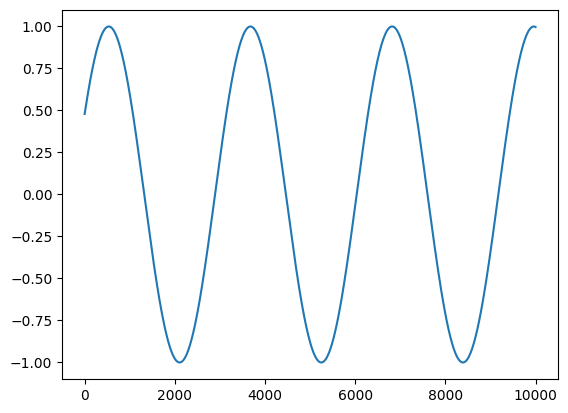

In [182]:
#Exercise 5.2

# generate 1000 points 
nsample = 10000
x=range(1,nsample+1)
## simulate a simple sinusoidal function
ns = np.linspace(0, 10, nsample)
y = pd.Series(1*np.sin(2.0 * ns + .5), dtype = float, index=x)
y.plot()
print("ADF pVal: {0}".format(adfuller(y, autolag=None)[1])) #if less than 0.05 means stationary

ADF pVal: 1.0


<Axes: >

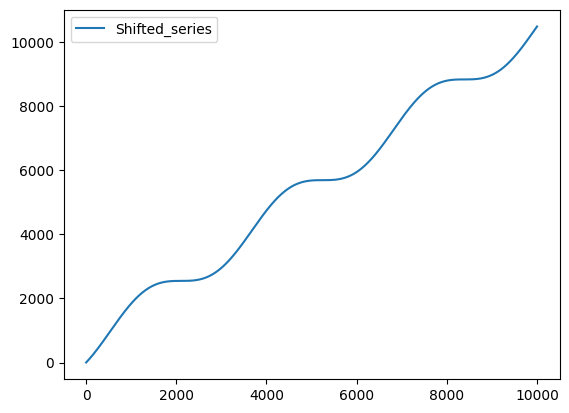

In [183]:
c_constant = 1.
y_shifted = (y + c_constant).cumsum().rename('Shifted_series').to_frame()
print("ADF pVal: {0}".format(adfuller(y_shifted.squeeze(), autolag=None)[1])) #if less than 0.05 means stationary
y_shifted.plot()

In [208]:
# this might take 2 mins
# pls note that not all log time-series data will improve convergence, kindly check with final result

def min_value(data: pd.Series, func, thres = 0.01, pval_threshold: float = 0.05):
    d_domain = np.linspace(start = 0, 
                           stop = 1, 
                           num=100, 
                           endpoint=True, 
                           retstep=False, 
                           dtype=float)
    for d in d_domain:
        df2 = func(data,d,thres = thres).dropna()
        df2 = adfuller(df2.squeeze(), maxlag=1, regression='c', autolag=None)
        try:
            if df2[1] <= pval_threshold:
                return round(d, 6)
        except:
            print('Something is wrong! Most likely required d value more than 2!!')

min_value(y_shifted, func = fracDiff)

np.float64(0.020202)

In [211]:
np.linspace(start = 0, 
                           stop = 1, 
                           num=100, 
                           endpoint=True, 
                           retstep=False, 
                           dtype=float)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [212]:
np.linspace(0, 1, 20)

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [210]:
ds = np.linspace(start = 0, 
                           stop = 1, 
                           num=100, 
                           endpoint=True, 
                           retstep=False, 
                           dtype=float)
for d in ds:
    sin_diff = fracDiff(series=y_shifted, d=d, thres=0.01).dropna()
    p_val = adfuller(sin_diff.squeeze(), maxlag=1, regression='c', autolag=None)[1]
    if p_val <= 0.05:
        print("The smallest d value with p_value below 5% is: ", d)
        print("The p-value is: ", p_val)
        break

The smallest d value with p_value below 5% is:  0.020202020202020204
The p-value is:  8.912552053232487e-26


In [203]:
df = fracDiff(y_shifted, d =0.0202, thres=.01)

In [204]:
df

,Shifted_series
4934,4802.625392
4935,4802.725614
4936,4802.824847
4937,4802.923091
4938,4803.020351
...,...
9996,8774.978292
9997,8776.675060
9998,8778.371640
9999,8780.068027


In [149]:
df = fracDiff(y_shifted, d =0.0202, thres=.01)
print("ADF pVal: {0}".format(adfuller(df['Shifted_series'].dropna(),
                                  maxlag=1,
                                  regression='c',
                                  autolag=None)[1])) #if less than 0.05 means stationary

ADF pVal: 8.91867992748415e-26


In [185]:
min_value(y_shifted, thres = 1e-5, func = fracDiff_FFD)

np.float64(0.020202)

In [147]:
df1 = fracDiff_FFD(y_shifted, d = 0.0202, thres=1e-5)
print("ADF pVal: {0}".format(adfuller(df1['Shifted_series'].dropna(), 
                                  maxlag=1, 
                                  regression='c', 
                                  autolag=None)[1])) #if less than 0.05 means stationary

ADF pVal: 1.4453943335420127e-16
